In [4]:
import math  
import pandas as pd  
import numpy as np  
import requests  
import json
import sklearn
import nltk
import re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

/Users/lheinle/anaconda/envs/data-analysis/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's grab the tweets

In [75]:
import os
import twitter
from textblob import TextBlob

In [6]:
twitter_key = os.environ.get('TWITTER_CONSUMER_KEY')
twitter_secret = os.environ.get('TWITTER_CONSUMER_SECRET')
twitter_token = os.environ.get('TWITTER_ACCESS_TOKEN')
twitter_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

In [7]:
api = twitter.Api(consumer_key=twitter_key,
                  consumer_secret=twitter_secret,
                  access_token_key=twitter_token,
                  access_token_secret=twitter_token_secret)

In [339]:
tweets=api.GetUserTimeline('826036134', include_rts=False, count=200)
print(tweets[0])
print(len(tweets))

{"created_at": "Mon Jul 03 12:31:23 +0000 2017", "favorite_count": 3, "hashtags": [{"text": "dadjokes"}], "id": 881852870462763008, "id_str": "881852870462763008", "lang": "en", "place": {"attributes": {}, "bounding_box": {"coordinates": [[[-78.912276, 42.826008], [-78.79485, 42.826008], [-78.79485, 42.966451], [-78.912276, 42.966451]]], "type": "Polygon"}, "contained_within": [], "country": "United States", "country_code": "US", "full_name": "Buffalo, NY", "id": "a307591cd0413588", "name": "Buffalo", "place_type": "city", "url": "https://api.twitter.com/1.1/geo/id/a307591cd0413588.json"}, "quoted_status": {"created_at": "Mon Jul 03 12:09:05 +0000 2017", "favorite_count": 2, "hashtags": [{"text": "LancasterNY"}], "id": 881847259436068865, "id_str": "881847259436068865", "lang": "en", "retweet_count": 2, "source": "<a href=\"https://secure.echoboxapp.com\" rel=\"nofollow\">Echobox Social</a>", "text": "Patriotic dogs and their owners paraded in #LancasterNY on Sunday. Gallery by @DerekG

In [210]:
cleaner_tweets = []
for tweet in tweets:
    cleaner_tweets.append({'id': tweet.id, 'text': tweet.text, 'created_at': tweet.created_at, 'profile': tweet.user.screen_name})
    


In [211]:
trumpTweets=api.GetUserTimeline('25073877', include_rts=False, count=200)
print(trumpTweets[0])
print(len(trumpTweets))

{"created_at": "Mon Jul 03 14:00:21 +0000 2017", "favorite_count": 57204, "hashtags": [{"text": "CharlieGard"}], "id": 881875263700783104, "id_str": "881875263700783104", "lang": "en", "retweet_count": 19577, "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>", "text": "If we can help little #CharlieGard, as per our friends in the U.K. and the Pope, we would be delighted to do so.", "urls": [], "user": {"created_at": "Wed Mar 18 13:46:38 +0000 2009", "description": "45th President of the United States of America", "favourites_count": 24, "followers_count": 33192629, "friends_count": 45, "geo_enabled": true, "id": 25073877, "lang": "en", "listed_count": 72461, "location": "Washington, DC", "name": "Donald J. Trump", "profile_background_color": "6D5C18", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg", "profile_background_tile": true, "profile_banner_url": "https://pb

In [212]:
for tweet in trumpTweets:
    cleaner_tweets.append({'id': tweet.id, 'text': tweet.text, 'created_at': tweet.created_at, 'profile': tweet.user.screen_name})
    


In [214]:
df = pd.DataFrame(cleaner_tweets)
df.tail()

,created_at,id,profile,text
300,Tue Jun 06 12:06:35 +0000 2017,872062159789985792,realDonaldTrump,During my recent trip to the Middle East I sta...
301,Tue Jun 06 11:58:00 +0000 2017,872059997429022722,realDonaldTrump,The FAKE MSM is working so hard trying to get ...
302,Tue Jun 06 10:51:39 +0000 2017,872043300949295104,realDonaldTrump,Big meeting today with Republican leadership c...
303,Tue Jun 06 01:20:17 +0000 2017,871899511525961728,realDonaldTrump,"That's right, we need a TRAVEL BAN for certain..."
304,Mon Jun 05 21:25:16 +0000 2017,871840367070412800,realDonaldTrump,"Today, I announced an Air Traffic Control Init..."


In [215]:
from datetime import datetime
df['created_at'] = df['created_at'].apply(lambda x: datetime.strptime(x , "%a %b %d %H:%M:%S %z %Y"))

In [216]:
df.head()

,created_at,id,profile,text
0,2017-07-03 12:31:23+00:00,881852870462763008,lexieheinle,"Aww, look at the paw-traits! #dadjokes https:/..."
1,2017-06-17 00:14:09+00:00,875869134302720000,lexieheinle,@buffalobison Despacito #attjukebox
2,2017-06-15 23:47:05+00:00,875499936590303232,lexieheinle,@tackjhompson I may be absurdly proud of my ti...
3,2017-06-15 23:01:56+00:00,875488575726530561,lexieheinle,Colorful crowd at the #CorporateChallenge http...
4,2017-06-15 14:26:34+00:00,875358879512748032,lexieheinle,Will I nerd out about one of my favorite proje...


In [312]:
def preProcessing(titles):
    num_titles = len(titles)
    titles = titles.lower()
    word_phrase = titles.split(' ')
    clean_phrase = []
    stops = set(stopwords.words("english"))
    for i in range( 0, len(word_phrase)):
        letters_only = re.split("[^a-zA-Z]", word_phrase[i]) 
        clean_list = []
        for letter in letters_only:
            if letter not in stops and letter != '':
                clean_list.append(letter)
        words = ''.join(clean_list)
        print('words = {0}'.format(words))
        if not words in stops and not 'https' in words:
            clean_phrase.append("".join(words))
    print(' '.join(clean_phrase))
    return ' '.join(clean_phrase)

In [313]:
df['clean_text'] = df['text'].apply(lambda x: preProcessing(x))

words = aww
words = look
words = 
words = 
words = pawtraits
words = dadjokes
words = httpscoluazxgn
aww look   pawtraits dadjokes
words = buffalobison
words = despacito
words = attjukebox
buffalobison despacito attjukebox
words = tackjhompson
words = 
words = may
words = 
words = absurdly
words = proud
words = 
words = 
words = time
words = httpscognltgqa
tackjhompson  may  absurdly proud   time
words = colorful
words = crowd
words = 
words = 
words = corporatechallenge
words = httpscontzrqsuw
colorful crowd   corporatechallenge
words = 
words = 
words = nerd
words = 
words = 
words = one
words = 
words = 
words = favorite
words = projects
words = yes
words = yes
words = 
words = 
words = httpscopcbrqzz
words = httpsconodxtewn
  nerd   one   favorite projects yes yes  
words = ditto
words = httpscovmuyosujl
ditto
words = loving
words = puddingviz
words = june
words = take
words = 
words = bias
words = 
words = wrote
words = gender
words = balance
words = 
words = 
words = new
words = 

words = 
words = shopping
words = list
words = computer
words = 
words = 
words = weather
words = today
words = joys
words = 
words = amazon
words = employing
words = star
words = trek
words = fans
 morning computer add bread   shopping list computer   weather today joys  amazon employing star trek fans
words = trump
words = connections
words = httpscouysnh
words = via
words = kimay
trump connections via kimay
words = spotify
words = throwbackthursday
words = playlist
words = 
words = 
words = soundtrack
words = 
words = 
words = childhood
words = aka
words = 
words = 
words = 
words = music
words = 
words = parents
words = love
words = httpscoghfdwdhoi
spotify throwbackthursday playlist   soundtrack   childhood aka    music  parents love
words = 
words = 
words = google
words = maps
words = 
words = helping
words = 
words = pick
words = 
words = least
words = busy
words = time
words = 
words = dmv
words = 
words = 
words = 
words = 
words = minutes
  google maps  helping  pick  least 

words = electronic
words = surveillance
words = intercepts
words = unmasking
words = 
words = illegal
words = leaking
words = 
words = information
words = 
words = 
words = 
words = idea
    recently reported electronic surveillance intercepts unmasking  illegal leaking  information    idea
words = 
words = certainly
words = hope
words = 
words = democrats
words = 
words = 
words = force
words = nancy
words = p
words = 
words = 
words = would
words = 
words = 
words = bad
words = 
words = 
words = republican
words = party
words = 
words = 
words = please
words = let
words = cryin
words = chuck
words = stay
 certainly hope  democrats   force nancy p   would   bad   republican party   please let cryin chuck stay
words = 
words = 
words = 
words = dnc
words = refuse
words = 
words = turn
words = 
words = 
words = server
words = 
words = 
words = fbi
words = 
words = still
words = 
words = 
words = 
words = 
words = big
words = dem
words = scam
words = 
words = excuse
words = 
words = losi

In [314]:
df.tail()

,created_at,id,profile,text,clean_text,polarity,subjectivity,polarityFeeling,subjectivityFeeling,np_counts
300,2017-06-06 12:06:35+00:00,872062159789985792,realDonaldTrump,During my recent trip to the Middle East I sta...,recent trip middle east stated longer...,0.000000,0.125000,neutral,positive,"{'recent trip middle': 1, 'radical ideology le..."
301,2017-06-06 11:58:00+00:00,872059997429022722,realDonaldTrump,The FAKE MSM is working so hard trying to get ...,fake msm working hard trying get use so...,-0.191667,0.681667,negative,positive,"{'fake msm': 1, 'social media': 1}"
302,2017-06-06 10:51:39+00:00,872043300949295104,realDonaldTrump,Big meeting today with Republican leadership c...,big meeting today republican leadership conce...,-0.001984,0.392460,negative,positive,"{'big meeting': 1, 'republican leadership': 1,..."
303,2017-06-06 01:20:17+00:00,871899511525961728,realDonaldTrump,"That's right, we need a TRAVEL BAN for certain...",right need travel ban certain dangerous co...,-0.025000,0.526786,negative,positive,"{'right need travel ban': 1, 'certain dangerou..."
304,2017-06-05 21:25:16+00:00,871840367070412800,realDonaldTrump,"Today, I announced an Air Traffic Control Init...",today announced air traffic control initiati...,0.000000,0.375000,neutral,positive,"{'air traffic control initiative': 1, 'america..."


In [315]:
def sentimentize(tweet, variable):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    analysis = TextBlob(tweet)
    variableMeasure = getattr(analysis.sentiment,variable)
    return variableMeasure
    if variableMeasure > 0:
        return 'positive'
    elif variableMeasure == 0:
        return 'neutral'
    else:
        return 'negative'

def sentimentize_feeling(tweet, variable):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    analysis = TextBlob(tweet)
    variableMeasure = getattr(analysis.sentiment,variable)
    if variableMeasure > 0:
        return 'positive'
    elif variableMeasure == 0:
        return 'neutral'
    else:
        return 'negative'

In [316]:
df['polarity'] = df['clean_text'].apply(lambda x: sentimentize(x, 'polarity'))
df['subjectivity'] = df['clean_text'].apply(lambda x: sentimentize(x, 'subjectivity'))
df['polarityFeeling'] = df['clean_text'].apply(lambda x: sentimentize_feeling(x, 'polarity'))
df['subjectivityFeeling'] = df['clean_text'].apply(lambda x: sentimentize_feeling(x, 'subjectivity'))

In [317]:
df.head()

,created_at,id,profile,text,clean_text,polarity,subjectivity,polarityFeeling,subjectivityFeeling,np_counts
0,2017-07-03 12:31:23+00:00,881852870462763008,lexieheinle,"Aww, look at the paw-traits! #dadjokes https:/...",aww look pawtraits dadjokes,0.3,0.9,positive,positive,{'aww look paw traits dadjokes': 1}
1,2017-06-17 00:14:09+00:00,875869134302720000,lexieheinle,@buffalobison Despacito #attjukebox,buffalobison despacito attjukebox,0.0,0.0,neutral,neutral,{'buffalobison despacito attjukebox': 1}
2,2017-06-15 23:47:05+00:00,875499936590303232,lexieheinle,@tackjhompson I may be absurdly proud of my ti...,tackjhompson may absurdly proud time,0.8,1.0,positive,positive,{'proud time': 1}
3,2017-06-15 23:01:56+00:00,875488575726530561,lexieheinle,Colorful crowd at the #CorporateChallenge http...,colorful crowd corporatechallenge,0.3,0.4,positive,positive,{'colorful crowd corporatechallenge': 1}
4,2017-06-15 14:26:34+00:00,875358879512748032,lexieheinle,Will I nerd out about one of my favorite proje...,nerd one favorite projects yes yes,0.5,1.0,positive,positive,{'favorite projects yes yes': 1}


In [318]:
polarity = pd.DataFrame(df.groupby(['polarityFeeling', 'profile']).size().rename('counts')).astype(int)
polarity['percent'] = polarity['counts'].apply(lambda x: x/polarity.sum())
polarity


counts   percent
polarityFeeling profile                          
negative        lexieheinle          25  0.081967
                realDonaldTrump      37  0.121311
neutral         lexieheinle          49  0.160656
                realDonaldTrump      47  0.154098
positive        lexieheinle          57  0.186885
                realDonaldTrump      90  0.295082

In [319]:
subjectivity = pd.DataFrame(df.groupby(['subjectivityFeeling', 'profile']).size().rename('counts')).astype(int)
subjectivity['percent'] = subjectivity['counts'].apply(lambda x: x/subjectivity.sum())
subjectivity

counts   percent
subjectivityFeeling profile                          
neutral             lexieheinle          41  0.134426
                    realDonaldTrump      39  0.127869
positive            lexieheinle          90  0.295082
                    realDonaldTrump     135  0.442623

In [320]:
def percentConvert(value):
    full = value * 100
    return '{0:.1f}'.format(full)

In [195]:
"In the last {0} tweets, I've been postive {1} percent, negative {2} percent and neutral {3} percent".format(polarity.sum().counts, percentConvert(polarity.loc["positive"].percent), percentConvert(polarity.loc["negative"].percent), percentConvert(polarity.loc["neutral"].percent))

"In the last 131.0 tweets, I've been postive 43.5 percent, negative 19.1 percent and neutral 37.4 percent"

In [198]:
"In the last {0} tweets, I've been most subjective {1} percent and neutral {2} percent".format(subjectivity.sum().counts, percentConvert(subjectivity.loc["positive"].percent), percentConvert(subjectivity.loc["neutral"].percent))

"In the last 131.0 tweets, I've been most subjective 69.5 percent and neutral 30.5 percent"

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

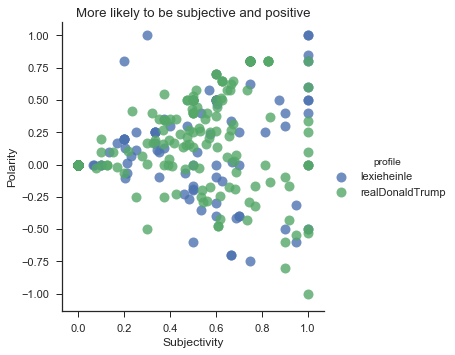

In [322]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")


sns.lmplot('subjectivity','polarity',
           data=df,
           fit_reg=False,
           hue="profile",
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('More likely to be subjective and positive')
plt.ylabel('Polarity')
plt.xlabel('Subjectivity')

In [323]:
masterList = {'lexieheinle': {}, 'realDonaldTrump': {}}
def get_np_counts(tweet, profile):
    analysis = TextBlob(tweet)
    return analysis.np_counts
print(masterList)

{'lexieheinle': {}, 'realDonaldTrump': {}}


In [324]:
df['np_counts'] = df['clean_text'].apply(lambda x: get_np_counts(x, df['profile']))

In [325]:
df.loc[0]

created_at                                     2017-07-03 12:31:23+00:00
id                                                    881852870462763008
profile                                                      lexieheinle
text                   Aww, look at the paw-traits! #dadjokes https:/...
clean_text                                 aww look   pawtraits dadjokes
polarity                                                             0.3
subjectivity                                                         0.9
polarityFeeling                                                 positive
subjectivityFeeling                                             positive
np_counts                             {'aww look pawtraits dadjokes': 1}
Name: 0, dtype: object

In [350]:
for index, row in df.iterrows():
    clean_tweet = re.match('(.*?)http.*?\s?(.*?)', row.loc['text'])
    if clean_tweet:
        text = clean_tweet.group(1)
        print('text = {0}'.format(text))
        print('bjkaljdgkla')
        cleaner_tweet = re.sub(r'...', ' ', text)
        if text != cleaner_tweet:
            print('cleaner tweet = {0}'.format(cleaner_tweet))
    else:
        text = row.loc['text']
        print('text = {0}'.format(text))
        cleaner_tweet = re.sub(r'...', ' ', text)
    analysis = TextBlob(text)
    phrase_counts = analysis.np_counts
    profile = row.loc['profile']
    #print(analysis.word_counts)
    for key, value in phrase_counts.items():
        print(key)
        if key not in masterList[profile]:
            masterList[profile][key] = value
        else:
            new_value = masterList[profile][key] + value
            masterList[profile][key] = new_value

text = Aww, look at the paw-traits! #dadjokes 
bjkaljdgkla
cleaner tweet =              
aww
# dadjokes
text = @buffalobison Despacito #attjukebox
@ buffalobison
despacito
# attjukebox
text = @tackjhompson I may be absurdly proud of my time 
bjkaljdgkla
cleaner tweet =                  
@ tackjhompson
text = Colorful crowd at the #CorporateChallenge 
bjkaljdgkla
cleaner tweet =               
colorful crowd
corporatechallenge
text = Will I nerd out about one of my favorite projects? Yes, yes I will. 
bjkaljdgkla
cleaner tweet =                       . 
will
favorite projects
text = Ditto... 
bjkaljdgkla
cleaner tweet =    
ditto
text = Loving @puddingviz's June take on Bias, She Wrote
The Gender Balance of The New York Times Best Seller list https://t.co/CaqUR1NkNX
loving
@ puddingviz 's
june
bias
wrote
gender balance
york
seller
list https
text = We've published all the code and data on GitHub. Here's a link to the raw (yet geocoded) shooting data:… 
bjkaljdgkla
cleaner tweet =       

cleaner tweet =                      c 
coffee shop
text = I think prepping for events like #BNSnow will be one of my favorite job duties. 
bjkaljdgkla
cleaner tweet =                           . 
bnsnow
favorite job duties
text = Tonight, I'm enjoying the Christmas lights before tomorrow's promised blizzard. #twitter 
bjkaljdgkla
cleaner tweet =                              r 
christmas
# twitter
text = Dear Amazon, please deliver my snow shovel/brush before...'Localized blizzard conditions' possible Wednesday 
bjkaljdgkla
cleaner tweet =                                      
dear amazon
snow shovel/brush
blizzard conditions
text = 7,500 Faceless Coders Paid in Bitcoin Built a Hedge Fund’s Brain 
bjkaljdgkla
cleaner tweet =                      n 
faceless coders paid
bitcoin built
hedge
fund ’ s brain
text = Thoughts cleaning snow off of my car:
1. "This stinks."
2. "I wish someone was around to hit with this snowball."
thoughts
text = S/O to this great Amazon review for helping me t

In [341]:
masterList['realDonaldTrump']

{'% increases': 7,
 "'no sanctuary": 7,
 "'s 5th district": 14,
 "'s assurances": 7,
 "'s future security": 7,
 "'s men": 7,
 "'s opponent": 7,
 '... .because': 7,
 '... .the': 7,
 '... extremism': 7,
 '... way': 7,
 '//t.co/8kmca6ytfd https': 6,
 '//t.co/i8cqkgdk2b https': 7,
 '//t.co/syjugomhhj #': 7,
 '9-o decision': 7,
 '@ foxandfriends': 28,
 '@ nbc': 7,
 '@ nytimes': 14,
 '@ washingtonpost': 7,
 'a.g. lynch': 7,
 'abc': 14,
 'able show proof': 1,
 'accurate election trump approval': 1,
 'action focus': 1,
 'advisor jeh johnson': 7,
 'afternoon.… https': 6,
 'afternoon.🇺🇸🇵🇦 ➡️… https': 7,
 'air traffic control': 14,
 'air traffic control initiative': 1,
 'aluminum amp steel time': 1,
 'amazon': 7,
 'amazonwashingtonpost': 7,
 'america': 63,
 'america men amp women uniform story freedom': 1,
 'america safe': 7,
 'america whitehouse infrastructure summit': 1,
 'america worship government worship god': 1,
 'americafirst': 14,
 'americafirst infrastructureweek': 1,
 'americafirst ty':

In [342]:
masterList['lexieheinle']

{'# attjukebox': 7,
 '# dadjokes': 1,
 '# dadjokes https': 6,
 '# dataviz': 7,
 '# drone test': 7,
 '# drones #': 7,
 '# privacyparadox': 1,
 '# privacyparadox https': 6,
 '# twitter': 1,
 '# twitter https': 6,
 "'i didn ’ t": 7,
 "'m feeling": 7,
 "'s #": 7,
 "'s part": 7,
 "'s piece": 7,
 "'s treasure": 1,
 "'s treasure https": 6,
 "'s winner": 7,
 '... https': 12,
 '//t.co/ifpiegq3uq # dataviz': 6,
 '//t.co/ltpjngfcoj https': 6,
 '//t.co/pc1brqzz49 https': 6,
 '//t.co/tcou3jbg5m https': 6,
 '//t.co/vvv4lnykw0 #': 6,
 '//t.co/zemjlmodlg #': 6,
 '80s music': 7,
 '@ _aconnolly_': 7,
 "@ bobrieneden 's lead": 7,
 '@ buffalobison': 7,
 '@ cody_winchester': 7,
 '@ emnohr @': 7,
 '@ flowingdata': 6,
 '@ kimay': 6,
 '@ lamthuyvo': 6,
 '@ lexieheinle ...': 7,
 '@ maireadsafranek': 7,
 '@ mattwaite': 21,
 '@ mattwaite yeah': 7,
 '@ mbostock': 1,
 '@ mbostock https': 6,
 '@ mhanson2143': 14,
 '@ mourner': 1,
 '@ mourner https': 6,
 '@ newscane @': 7,
 '@ onlyandrewn': 7,
 '@ owhnews': 6,
 "@ p

In [281]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '